In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch import Tensor
from torch.nn.init import xavier_normal

from torch.utils.data import DataLoader, Dataset

import numpy as np

import os
import random

from tqdm import tqdm_notebook

from pycrayon import CrayonClient

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

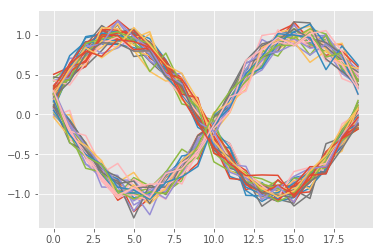

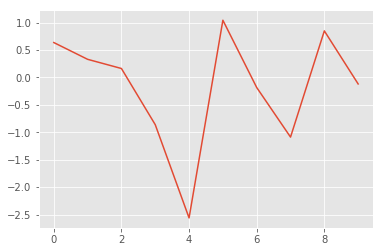

AttributeError: 'tuple' object has no attribute 'numpy'

In [2]:
D_hid = 64
D_layers = 1

G_hid = 32 
G_layers= 1

mb_size = 64
seq_len = 20
z_dim = 10
c_dim = 10
n_classes = 2


def g_noise():
    return (torch.randn(seq_len, mb_size, z_dim))

def pretrain_noise():
    noise = g_noise()
    seqs, _ = real_sample()
    inp = torch.cat([seqs[:,:,:], noise], 2)
    return inp, seqs
    
def real_sample():
    shift_choices = [-1, 2]
    shift = np.random.choice(shift_choices, mb_size)
    freq = np.ones(mb_size) * 3
    support = np.linspace(-1, 1, seq_len)
    seqs = np.array([np.sin((support + shift[i])*freq[i]) 
                   for i in range(mb_size)])
    seqs = seqs.T.reshape(seq_len, mb_size, 1)
    seqs += np.random.normal(size=seqs.shape) * 1e-1
    return Tensor(seqs), 3

u, s = real_sample()
u = u.numpy()
plt.plot(u[:,:,0])
plt.show()

v = g_noise().numpy()
plt.plot(v[0,0,:])
plt.show()

w = pretrain_noise().numpy()
plt.plot(w[:,0,0])
plt.show()

In [3]:
class Logger():
    def __init__(self, exp_name):
        self.cc = CrayonClient(hostname='localhost')
        names = self.cc.get_experiment_names()
        self.cc.remove_experiment(exp_name)
        self.exp = self.cc.create_experiment(exp_name)
        
    def log_scalar(self, key, val):
        self.exp.add_scalar_value(key, val)
        
    def log_hist(self, key, val):
        self.exp.add_histogram_value(key, val, tobuild=True)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gru = nn.GRU(
            input_size=z_dim+1, 
            hidden_size=G_hid,
            num_layers=G_layers,
            dropout=0.0
        )
        self.decode1 = nn.Linear(G_hid, 1)
        
    def forward(self, z):
        hidden = self.init_hidden()
        zs = list(torch.split(z, 1, dim=0))
        output = Variable(torch.zeros(1,mb_size,1)).cuda()
        outputs = []
        for _ in range(seq_len):
            zz = torch.cat([output, zs.pop()], 2)
            output, hidden = self.gru(zz)
            output = F.tanh(self.decode1(output))
            outputs.append(output)
            
        outputs = torch.cat(outputs, 0)
        return outputs

    def forward_pretrain(self, z):
        hidden = self.init_hidden()
        output, _ = self.gru(z, hidden)
        output = F.tanh(self.decode1(output))
        return output
    
    def init_hidden(self):
        return Variable(
            torch.zeros(G_layers, mb_size, G_hid)
        ).cuda()
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.gru = nn.GRU(
            input_size=1, 
            hidden_size=D_hid,
            num_layers=D_layers,
            bidirectional=True,
            dropout=0.0,
        )
        self.decode = nn.Linear(D_hid*2, 1)
    
    def forward(self, X):
        hidden = self.init_hidden()
        output, _ = self.gru(X, hidden)
        output = self.decode(output)
        return output[-1, :, :]
        

    def init_hidden(self):
        return Variable(
            torch.zeros(D_layers*2, mb_size, D_hid)
        ).cuda()
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)
    

    
G = Generator()
G.init_weights()
D = Discriminator()
D.init_weights()
G.cuda()
D.cuda()

ones_label = Variable(torch.ones(mb_size, 1)).cuda()
zeros_label = Variable(torch.zeros(mb_size, 1)).cuda()

G_solver = optim.SGD(G.parameters(), lr=1e-3)
D_solver = optim.SGD(D.parameters(), lr=1e-3)
#G_solver = optim.RMSprop(G.parameters(), lr=1e-3)
#D_solver = optim.RMSprop(D.parameters(), lr=1e-3)

def reset_grad():
    D.zero_grad()
    G.zero_grad() 
G

Generator (
  (gru): GRU(11, 32)
  (decode1): Linear (32 -> 1)
)

In [5]:
def show_seqs(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d[:,::ds,0])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.savefig('pics/train_epoch{}.pdf'.format(i))
    plt.plot(d[:,::ds,0])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.show()

def show_seqs_aux(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d[:,::ds,0])
    if title:
        plt.title(title)
    plt.savefig('{}.pdf'.format(i))
    plt.plot(d[:,::ds,0])
    if title:
        plt.title(title)
    plt.show()
    
def show_seqs_nosave(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    plt.show()   
    
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True

def show_grad(model, logger, hist_name):
    grads = []
    for name, param in model.named_parameters():
        grad = param.grad.data.cpu().numpy().flatten()
        grads += grad.tolist()
    logger.log_hist(hist_name, grads)
    

one = torch.FloatTensor([1])
mone = one * -1
one = one.cuda()
mone = mone.cuda()
        
        

In [6]:
e_bar = tqdm_notebook(range(1000))
G_losses = []
for j, it in enumerate(e_bar):
    G_loss_avg = 0
    n_batches = 100
    b_bar = tqdm_notebook(range(n_batches), leave=False)
    
    for i in b_bar:
        z, target = pretrain_noise()
        z = Variable(z).cuda()
        target = Variable(target).cuda()
                     
        output = G.forward_pretrain(z)
        
        pretrain_loss = F.mse_loss(output, target)
        pretrain_loss.backward()
        G_solver.step()
        pretrain_loss = pretrain_loss.data[0]
        
        b_bar.set_postfix(loss=pretrain_loss)
        G_loss_avg += pretrain_loss
        
    e_bar.set_postfix(loss=G_loss_avg/n_batches)
    G_loss_avg = 0
    
        

KeyboardInterrupt: 

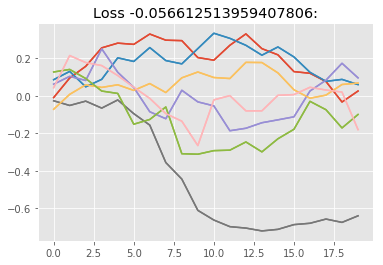

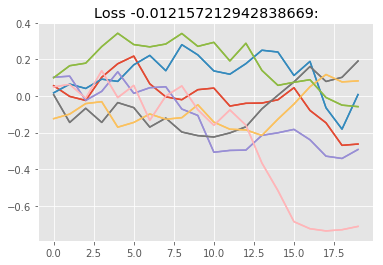

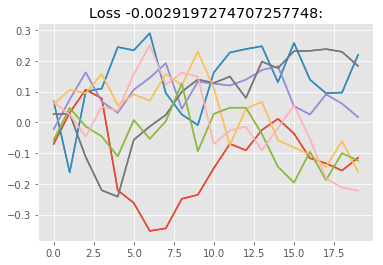

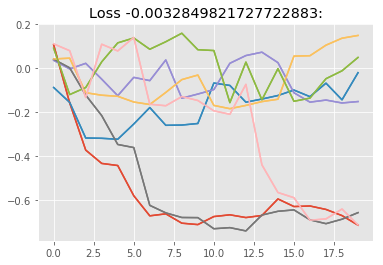

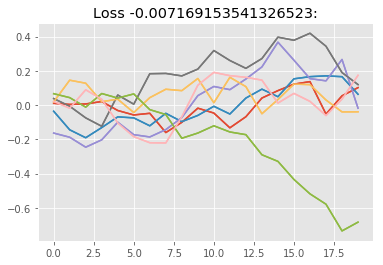

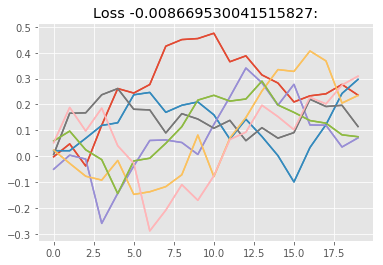

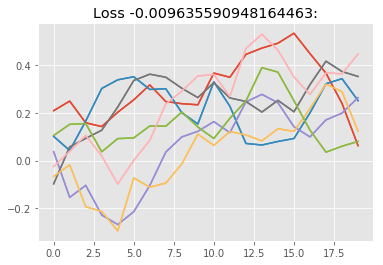

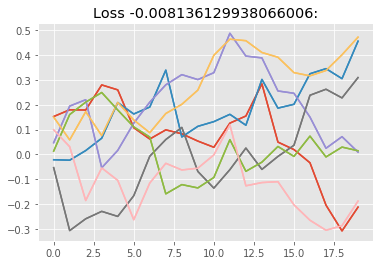

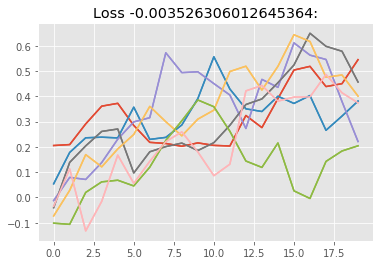

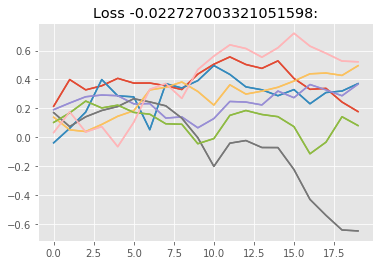

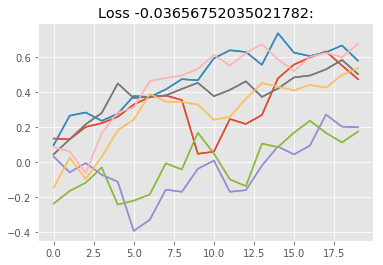

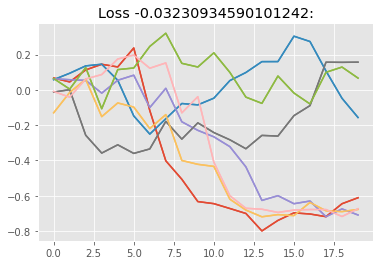

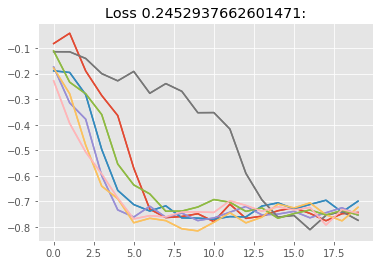

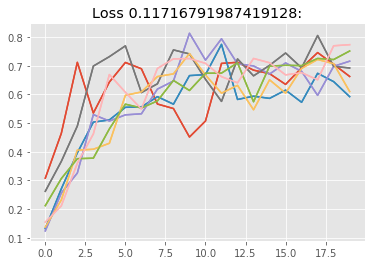

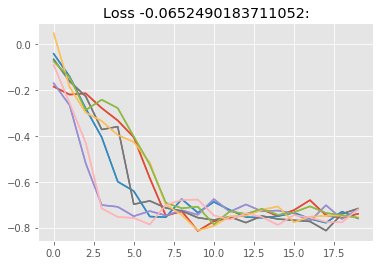

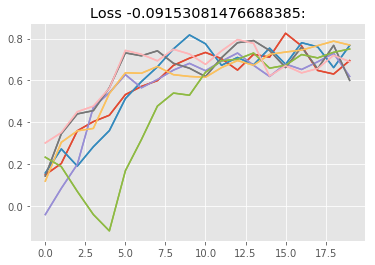

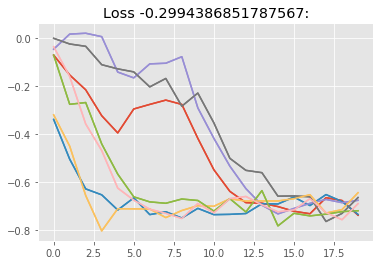

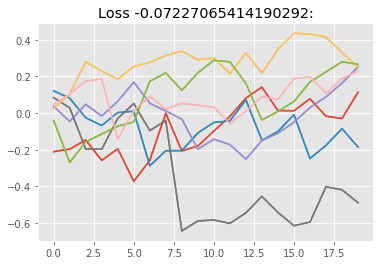

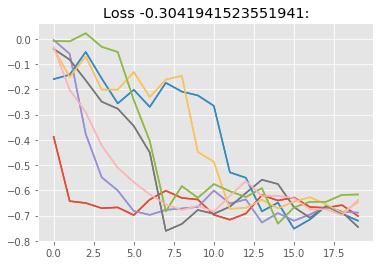

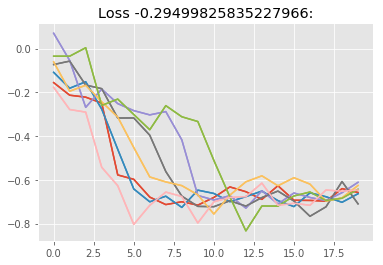

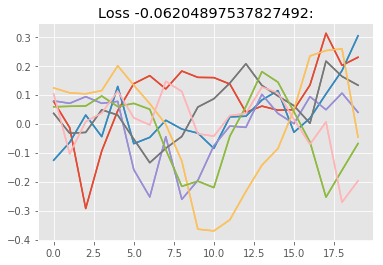

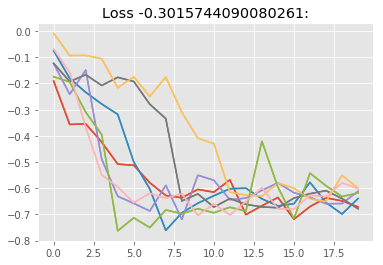

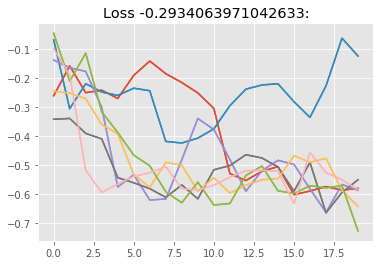

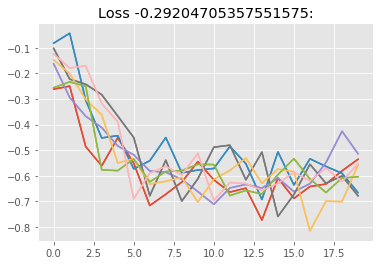

KeyboardInterrupt: 

In [7]:
e_bar = tqdm_notebook(range(1000))
G_losses = [1]
D_losses = [1]
logger = Logger('GAN-RNN-SIN')
for j, it in enumerate(e_bar):
    G_loss_avg = 0
    D_loss_avg = 0
    n_batches = 100
    b_bar = tqdm_notebook(range(n_batches), leave=False)
    
    DD = D_losses[-1]
    GG = G_losses[-1]
    
    for i in b_bar:
        z = Variable(g_noise()).cuda()
        X, _ = real_sample()
        X = Variable(X).cuda()
        
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)
        D_loss_real = F.binary_cross_entropy_with_logits(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy_with_logits(D_fake, zeros_label)     
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward(retain_graph=True)
        if DD / GG > 0.7: 
            D_solver.step()
        D_loss = D_loss.data[0]
        DD = D_loss / 2
        reset_grad()
        
        for _ in range(1):
            z = Variable(g_noise()).cuda()
            G_sample = G(z)
            D_fake = D(G_sample)
            G_loss = F.binary_cross_entropy_with_logits(
                D_fake, ones_label)
            G_loss.backward()
            if GG / DD > 0.7:
                G_solver.step()
            G_loss = G_loss.data[0]
            GG = G_loss
            reset_grad()
        
        D_loss_avg += D_loss
        G_loss_avg += G_loss
        
        
    G_losses.append(G_loss_avg / n_batches)
    D_losses.append(D_loss_avg / n_batches)
    G_loss_avg = 0
    D_loss_avg = 0
    
    t = D_fake.mean().data.cpu().numpy().flatten()[0]
    if j%10 == 0:
        show_seqs(G_sample, j, t, ds=10)
    logger.log_scalar('loss/Disciminator', D_losses[-1])
    logger.log_scalar('loss/Generator', G_losses[-1])
    e_bar.set_postfix(
        G_loss=G_losses[-1],
        D_loss=D_losses[-1],
    )

In [ ]:
for _ in range(1):
    z = Variable(g_noise()).cuda()
    ex = 5
    c = Variable(torch.ones(ex)).long().cuda() * 1
    G_sample = G(z[0:ex,:], c)
    ds = 1
    show_seqs_nosave(z[0:ex], ds=ds)
    show_seqs_nosave(G_sample[0:ex], ds=ds)

In [ ]:
for _ in range(1):
    z = Variable(g_noise()).cuda()
    c = Variable(torch.ones(5)).long().cuda() * 2
    G_sample = G(z[0:5,:], c)
    ds = 1
    show_seqs_nosave(z, ds=ds)
    show_seqs_aux(z[0:5],'input_noise', 'noise', ds=ds)
    #show_seqs_aux(G_sample,'gen', 'condition: 2', ds=ds)